In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def bachelier_formula_no_interest(t, St, T, sigma, K):
    d_time = T - t
    d_price = St - K
    return sigma ** 2 * d_time * stats.norm.pdf(d_price / (sigma ** 2 * d_time)) + d_price * stats.norm.cdf(d_price / (sigma ** 2 * d_time))

# def bachelier_formula(t, St, T, sigma, K, r):
#     v = sigma * np.sqrt((1 - np.exp(-2 * r * (T - t))) / (2 * r))
#     L = np.exp(- r * (T - t)) * K
#     d = St - L
#     return (St - L) * stats.norm.cdf(d / v) + v * stats.norm.pdf(d / v)

def bachelier(sigma, S, K, r, t):
    d = (S * np.exp(r*t) - K) / np.sqrt(sigma**2/(2 * r) * (np.exp(2*r*t)-1) )

    C = np.exp(-r * t) * (S * np.exp(r * t) - K) * stats.norm.cdf(d) + \
        np.exp(-r * t) * np.sqrt(sigma**2/(2*r) * (np.exp(2*r*t)-1) ) * stats.norm.pdf(d)

    return C

In [3]:
def monte_carlo_bachelier_with_interest(S0, T, sigma, K, r, N):
    Z = np.random.standard_normal(N)
    c = sigma * np.sqrt((np.exp(2 * r * T) - 1) / (2 * r))
    ST = S0 + c * Z
    return np.exp(-r * T) * np.maximum(ST - K, 0).mean()

In [4]:
def monte_carlo_bachelier(S0, T, sigma, K, N):
    Z = np.random.standard_normal(N)
    ST = S0 + sigma * np.sqrt(T) * Z
    return np.maximum(ST - K, 0).mean()

In [5]:
S0_values = np.linspace(80, 120, 200)
T_values = np.linspace(0.01, 1, 5)
K = 100
sigma = 0.1
r = 0.01
num_simulations = 10000

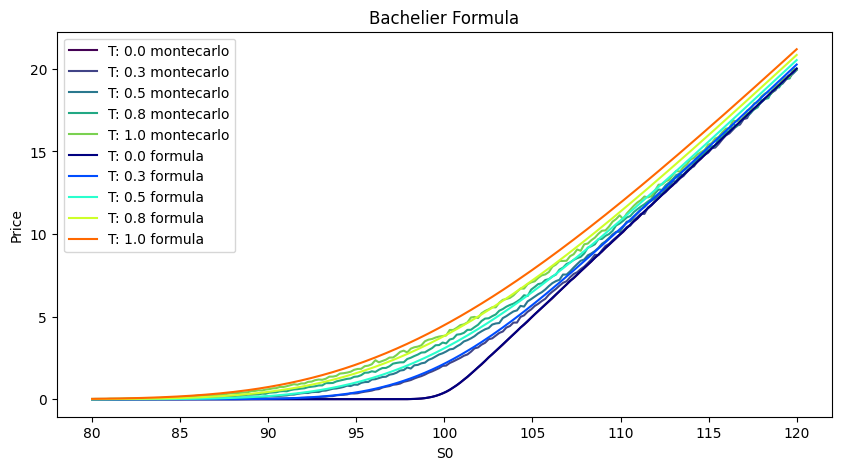

In [6]:
plt.figure(figsize=(10, 5))
colomap = plt.cm.viridis

for i in range(len(T_values)):
    prices_monte_carlo = [monte_carlo_bachelier_with_interest(S0, T_values[i], sigma * S0, K, r, num_simulations) for S0 in S0_values]
    plt.plot(S0_values, prices_monte_carlo, label=f"T: {T_values[i]:0.1f} montecarlo", color=colomap(i / len(T_values)))

plt.xlabel('S0')
plt.ylabel('Price')
plt.legend()
plt.title('Monte Carlo Bachelier Formula')
# plt.show()

# plt.figure(figsize=(10, 5))
colomap = plt.cm.jet

for i in range(len(T_values)):
    prices_formula = [bachelier(sigma * S0, S0, K, r, T_values[i]) for S0 in S0_values]
    plt.plot(S0_values, prices_formula, label=f"T: {T_values[i]:0.1f} formula", color=colomap(i / len(T_values)))

plt.xlabel('S0')
plt.ylabel('Price')
plt.legend()
plt.title('Bachelier Formula')
plt.show()

In [ ]:
S0_values = np.linspace(80, 120, 200)
T_values = np.linspace(0.01, 1, 5)
K = 100
sigma = 0.1
r = 0.01
num_simulations = 10000

Text(0.5, 1.0, 'Monte Carlo Bachelier Formula')

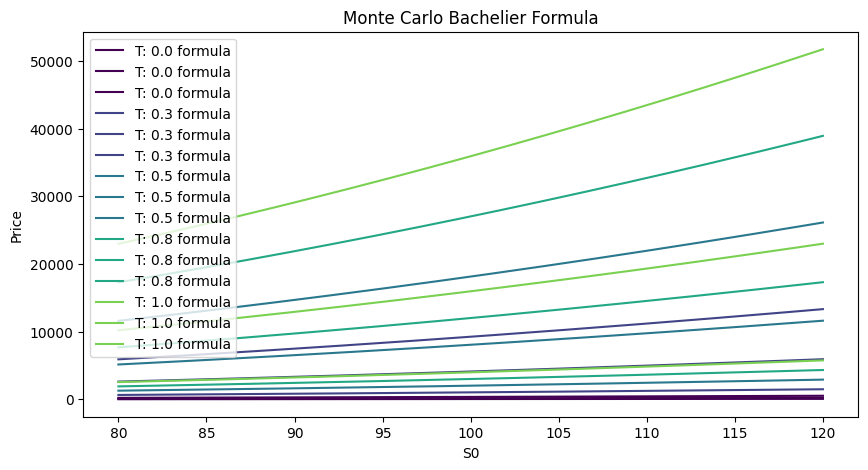

In [42]:
plt.figure(figsize=(10, 5))
colomap = plt.cm.viridis

for i in range(len(T_values)):
    prices_formula = [bachelier_formula_no_interest(0, S0, T_values[i], sigma * S0, K) for S0 in S0_values]
    plt.plot(S0_values, prices_formula, label=f"T: {T_values[i]:0.1f} formula", color=colomap(i / len(T_values)))

plt.xlabel('S0')
plt.ylabel('Price')
plt.legend()
plt.title('Monte Carlo Bachelier Formula')
# plt.show()

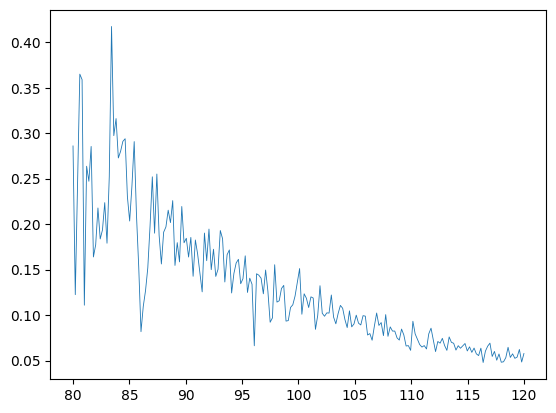

In [9]:
plt.plot(S0_values, np.abs((np.array(prices_formula) - np.array(prices_monte_carlo)) / np.array(prices_formula)), linewidth=0.6)

In [33]:
import numpy as np

# Assuming you have arrays sigma and cov
sigma = np.array([1, 2, 3])
# Cov is a 3x3 matrix
cov = np.array([[1, 5, 8], [4, 1, 6], [7, 8, 9]])

result = 0

for i in range(len(sigma)):
    for j in range(len(cov)):
        result += sigma[i]**2 * cov[i, j]**2

print(result)

result = np.sum(sigma**2 *cov**2)

print(result)

result = np.sum(sigma[:, np.newaxis]**2 * cov**2)

print(result)

2048
2055
2048


In [37]:
print(cov**2)
print(np.square(cov))

[[ 1 25 64]
 [16  1 36]
 [49 64 81]]
[[ 1 25 64]
 [16  1 36]
 [49 64 81]]


In [34]:
def bachelier_highdim(cov, sigma, S, K, r, t):
    dim = len(S)

    B = np.mean(S)
    trSS = np.sum(sigma**2 * cov**2) / dim**2

In [16]:
sigma = np.random.uniform(-5, 5, 3)
cov = np.random.uniform(-5, 5, (3, 3))

trSS = np.sum(sigma**2 * cov**2)
print(trSS)

trSS2 = 0
for i in range(3):
    for j in range(3):
        trSS2 += sigma[i]**2 * cov[i, j]**2

print(trSS2)

477.8489310375683
534.81904659848
